<h2>Description:</h2>
A framework for using machine learning to predict the future value of a timeseries.

<h2>Get all the things.</h2>

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from keras import layers
from tqdm import tqdm
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout,MaxPooling1D,GlobalAveragePooling1D
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
C:\Users\jwwilson\AppData\Local\Continuum\Anaconda2\envs\ztdl\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<h2>Define Some Parameters:</h2>

In [2]:
dataseries_length = 200
lookahead_fraction = 0.15 #fraction of dataset to look ahead.
nphases = 3 #number of independant sine wave in the dataset.
ntest = 60000 # number of tetset datapoints
ntrain = 120000 # number of training datapoints

<h2>Generate A Dataset of Complex Timeseries</h2>

In [190]:
#genearte a complex time series
def generateTimeSeries(length,ncomps):
    xx = np.arange(length)
    y = 0;
    for j in range(0,ncomps):
        period = np.random.rand(1)
        phase  = np.random.randint(length)
        y =  y+np.sin((xx+phase)*period/6.28)/period
    return y

#for baslining, leys look at a som of random numbers (random walk)
def generateCumSum(length,p1,ncomps):
    xx = np.random.randn(length)
    return np.cumsum(xx)

#takes a time series and splits it at a fraction of its length, and returns a point at the and for predicting.
def generateXy(series,fraction):
    xlen = series.shape[0]*fraction
    xlen = int(round(xlen))
    X = series[0:xlen]
    y = series[-1]
    return (X,y)

#combine multiple timeseries X,y points into a training set, normalize arch one.
def makeDataset(n): 
    A = []
    y = []
    for j in tqdm(range(0,n)):
        # Xtemp,ytemp = generateXy(generateCumSum(200,1,4),.5)
        Xtemp,ytemp = generateXy(generateTimeSeries(dataseries_length,nphases),1-lookahead_fraction)
        Xtemp = Xtemp.reshape(-1,1)
        ytemp = ytemp.reshape(-1,1)
        xmin = np.min(Xtemp)
        xmax = np.max(Xtemp)
        Xtemp = (Xtemp-xmin)/(xmax-xmin)
        ytemp = (ytemp-xmin)/(xmax-xmin)
        A.append(Xtemp)
        y.append(ytemp)      
    A = np.array(A)
    y = np.array(y)
    A = A.reshape(A.shape[0],A.shape[1])
    y = y.reshape(n)
    return (A,y)       

<h2>Build the dataset</h2>
Build training and testing dataset, and show a couple representative plots

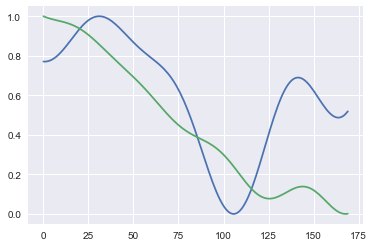

In [227]:
A,y = makeDataset(ntrain)
Aval,yval = makeDataset(ntest)
xx = range(0,A.shape[1])
_ = plt.plot(xx,A[0],xx,A[-1])

<h2>Define the 1st Model - Fully connected NN</h2>

In [248]:
model = Sequential()
model.add(Dense(A.shape[1],input_shape=(A.shape[1],),activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(128,activation = 'relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(128,activation = 'relu'))
model.add(Dense(64,activation = 'relu'))
model.add(Dense(32,activation = 'relu'))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 170)               29070     
_________________________________________________________________
dropout_7 (Dropout)          (None, 170)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               21888     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
__________

Train on 120000 samples, validate on 60000 samples
Epoch 1/50
4s - loss: 0.0578 - mean_absolute_error: 0.1721 - val_loss: 0.0522 - val_mean_absolute_error: 0.1670
Epoch 2/50
4s - loss: 0.0571 - mean_absolute_error: 0.1715 - val_loss: 0.0668 - val_mean_absolute_error: 0.1903
Epoch 3/50
4s - loss: 0.0567 - mean_absolute_error: 0.1710 - val_loss: 0.0699 - val_mean_absolute_error: 0.1973
Epoch 4/50
4s - loss: 0.0571 - mean_absolute_error: 0.1711 - val_loss: 0.0587 - val_mean_absolute_error: 0.1781
Epoch 5/50
4s - loss: 0.0570 - mean_absolute_error: 0.1711 - val_loss: 0.0581 - val_mean_absolute_error: 0.1719
Epoch 6/50
4s - loss: 0.0567 - mean_absolute_error: 0.1711 - val_loss: 0.0534 - val_mean_absolute_error: 0.1696
Epoch 7/50
4s - loss: 0.0568 - mean_absolute_error: 0.1708 - val_loss: 0.0515 - val_mean_absolute_error: 0.1623
Epoch 8/50
4s - loss: 0.0565 - mean_absolute_error: 0.1708 - val_loss: 0.0634 - val_mean_absolute_error: 0.1853
Epoch 9/50
5s - loss: 0.0567 - mean_absolute_error: 0

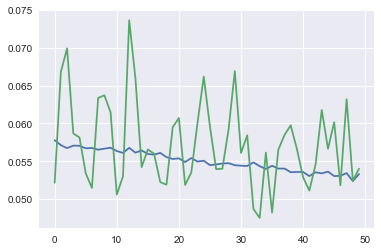

In [52]:
h = model.fit(A, y, batch_size=128, epochs=50, verbose=2,validation_data=(Aval, yval))
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

In [53]:
yfit = model.predict(Aval)
#yfitc1 = covmodel1.predict(Aval.reshape(30000,170,1))
#yfitc2 = covmodel2.predict(Aval.reshape(30000,170,1))


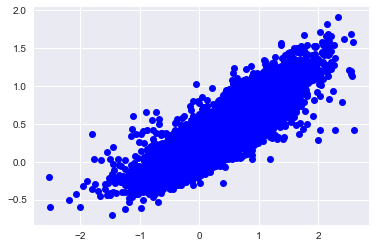

In [54]:
#yavg = (yfit+yfitc1+yfitc2)/3
plt.plot(yval,yfit,'bo')

In [55]:
np.corrcoef(yval.T,yfit.T)

array([[ 1.        ,  0.91720927],
       [ 0.91720927,  1.        ]])

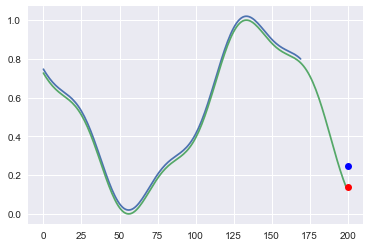

In [247]:
delta = 10
s = generateTimeSeries(200,3)
X1,y1 = generateXy(s,.85)
xmin = np.min(X1)
xmax = np.max(X1)
X1 = (X1-xmin)/(xmax-xmin)
y1 = (y1-xmin)/(xmax-xmin)
s = (s-xmin)/(xmax-xmin)
x = range(0,A.shape[1])
xx = range(0,200)
xxp = 200
p = covmodel1.predict(X1.reshape(1,170,1))
#p = model.predict(X1.reshape(-1,170))
#cp3 = covmodel3.predict(X1.reshape(1,370,1))
#cp2 = covmodel2.predict(X1.reshape(1,370,1))
#_= plt.plot(x,X1+.02,xx,s,xxp,y1,'ro',xxp,p,'bo',xxp,cp1,'go',xxp,cp2,'yo',xxp,cp3,'gx')
_ = plt.plot(x,X1+.02,xx,s,xxp,y1,'ro',xxp,p,'bo')
#print("p1 = {} p2 = {} p3 = {}".format(p1,p2,p3))

In [161]:
#yfit = model.predict(Aval).reshape(-1)
#lastp = Aval[:,169]
#delta = yval-lastp
#deltap = yfit-lastp
#plt.plot(deltap,delta,'bo')

lastp = Aval[:,169]
yfitc = covmodel1.predict(Aval.reshape(60000,170,1)).reshape(-1)
delta = yval-lastp
deltap = yfitc-lastp
#print("shapes = {},{},{}".format(yfitc.shape,yval.shape,lastp.shape))

In [162]:
n_correct = []
avgdelta = []
for p in np.arange(-100,100):
    deltagt = delta[deltap>p/100]
    sumd = np.sum(deltagt) 
    npoints = deltagt.shape[0] 
    avgdelta.append(sumd/npoints)
    nc = sum(deltagt>0)/sum(deltagt>-2)
    n_correct.append(nc)

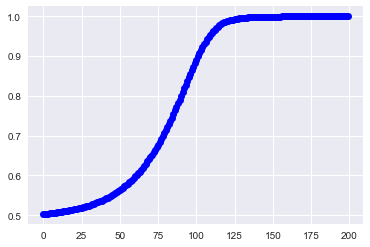

In [163]:
plt.plot(n_correct,'bo')

In [164]:
np.corrcoef(delta.T,deltap.T)

array([[ 1.        ,  0.92722763],
       [ 0.92722763,  1.        ]])

In [144]:
covmodel1 = Sequential()
covmodel1.add( Convolution1D( nb_filter=32, filter_length=10, input_shape=(A.shape[1], 1)))
covmodel1.add(Activation('relu'))
covmodel1.add(Flatten())
covmodel1.add(Dropout(0.4))
covmodel1.add(Dense(128, activation='relu'))
covmodel1.add(Dense(64, activation='relu'))
covmodel1.add(Dense(1))
covmodel1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
covmodel1.summary()

C:\Users\jwwilson\AppData\Local\Continuum\Anaconda2\envs\ztdl\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=32, input_shape=(170, 1), kernel_size=10)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 161, 32)           352       
_________________________________________________________________
activation_3 (Activation)    (None, 161, 32)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 5152)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5152)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               659584    
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total para

In [131]:
covmodel2 = Sequential()
covmodel2.add( Convolution1D( nb_filter=100, filter_length=20, input_shape=(A.shape[1], 1)))
covmodel2.add(Activation('relu'))
#model_m.add(MaxPooling1D(3))
#covmodel2.add(Dropout(0.4))
covmodel2.add(Dense(128, activation='relu'))
covmodel2.add(Dense(64, activation='relu'))
covmodel2.add(Dense(1))
covmodel2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
covmodel2.summary()

C:\Users\jwwilson\AppData\Local\Continuum\Anaconda2\envs\ztdl\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(filters=100, input_shape=(170, 1), kernel_size=20)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 151, 100)          2100      
_________________________________________________________________
activation_1 (Activation)    (None, 151, 100)          0         
_________________________________________________________________
dense_15 (Dense)             (None, 151, 128)          12928     
_________________________________________________________________
dense_16 (Dense)             (None, 151, 64)           8256      
_________________________________________________________________
dense_17 (Dense)             (None, 151, 1)            65        
Total params: 23,349
Trainable params: 23,349
Non-trainable params: 0
_________________________________________________________________


Train on 120000 samples, validate on 60000 samples
Epoch 1/20


 38272/120000 [========>.....................] - ETA: 126s - loss: 0.6097 - mean_absolute_error: 0.677 - ETA: 67s - loss: 1.3249 - mean_absolute_error: 0.936 - ETA: 55s - loss: 0.8976 - mean_absolute_error: 0.72 - ETA: 49s - loss: 0.7072 - mean_absolute_error: 0.62 - ETA: 46s - loss: 0.6003 - mean_absolute_error: 0.57 - ETA: 45s - loss: 0.5327 - mean_absolute_error: 0.53 - ETA: 43s - loss: 0.4828 - mean_absolute_error: 0.51 - ETA: 42s - loss: 0.4523 - mean_absolute_error: 0.50 - ETA: 42s - loss: 0.4251 - mean_absolute_error: 0.48 - ETA: 41s - loss: 0.4019 - mean_absolute_error: 0.47 - ETA: 40s - loss: 0.3849 - mean_absolute_error: 0.46 - ETA: 40s - loss: 0.3695 - mean_absolute_error: 0.45 - ETA: 40s - loss: 0.3532 - mean_absolute_error: 0.44 - ETA: 39s - loss: 0.3408 - mean_absolute_error: 0.43 - ETA: 39s - loss: 0.3336 - mean_absolute_error: 0.43 - ETA: 39s - loss: 0.3329 - mean_absolute_error: 0.43 - ETA: 38s - loss: 0.3231 - mean_absolute_error: 0.43 - ETA: 38s - loss: 0.3164 - mean

115456/120000 [===========================>..] - ETA: 13s - loss: 0.1328 - mean_absolute_error: 0.26 - ETA: 13s - loss: 0.1327 - mean_absolute_error: 0.26 - ETA: 13s - loss: 0.1325 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1323 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1321 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1320 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1318 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1317 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1315 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1313 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1312 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1311 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1309 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1308 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1307 - mean_absolute_error: 0.26 - ETA: 12s - loss: 0.1305 - mean_absolute_error: 0.26 - ETA: 11s - loss: 0.1304 - mean_absolute_error: 0.26 - ETA: 11s - loss: 0.1302 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.1169 - mean_absolute_error: 0.249 - ETA: 1s - loss: 0.1168 - mean_absolute_error: 0.248 - ETA: 1s - loss: 0.1169 - mean_absolute_error: 0.248 - ETA: 1s - loss: 0.1168 - mean_absolute_error: 0.248 - ETA: 1s - loss: 0.1167 - mean_absolute_error: 0.248 - ETA: 0s - loss: 0.1166 - mean_absolute_error: 0.248 - ETA: 0s - loss: 0.1165 - mean_absolute_error: 0.248 - ETA: 0s - loss: 0.1165 - mean_absolute_error: 0.248 - ETA: 0s - loss: 0.1164 - mean_absolute_error: 0.248 - ETA: 0s - loss: 0.1163 - mean_absolute_error: 0.248 - ETA: 0s - loss: 0.1162 - mean_absolute_error: 0.248 - ETA: 0s - loss: 0.1162 - mean_absolute_error: 0.248 - ETA: 0s - loss: 0.1161 - mean_absolute_error: 0.248 - ETA: 0s - loss: 0.1160 - mean_absolute_error: 0.247 - ETA: 0s - loss: 0.1160 - mean_absolute_error: 0.247 - ETA: 0s - loss: 0.1159 - mean_absolute_error: 0.247 - ETA: 0s - loss: 0.1158 - mean_absolute_error: 0.247 - ETA: 0s - loss: 0.1157 - mean_abs

 38144/120000 [========>.....................] - ETA: 41s - loss: 0.0784 - mean_absolute_error: 0.20 - ETA: 38s - loss: 0.0875 - mean_absolute_error: 0.20 - ETA: 38s - loss: 0.0935 - mean_absolute_error: 0.21 - ETA: 37s - loss: 0.0874 - mean_absolute_error: 0.20 - ETA: 37s - loss: 0.0850 - mean_absolute_error: 0.21 - ETA: 37s - loss: 0.0861 - mean_absolute_error: 0.21 - ETA: 36s - loss: 0.0843 - mean_absolute_error: 0.20 - ETA: 36s - loss: 0.0805 - mean_absolute_error: 0.20 - ETA: 36s - loss: 0.0823 - mean_absolute_error: 0.20 - ETA: 36s - loss: 0.0830 - mean_absolute_error: 0.20 - ETA: 36s - loss: 0.0819 - mean_absolute_error: 0.20 - ETA: 36s - loss: 0.0794 - mean_absolute_error: 0.20 - ETA: 36s - loss: 0.0784 - mean_absolute_error: 0.20 - ETA: 35s - loss: 0.0787 - mean_absolute_error: 0.20 - ETA: 35s - loss: 0.0784 - mean_absolute_error: 0.20 - ETA: 35s - loss: 0.0773 - mean_absolute_error: 0.19 - ETA: 35s - loss: 0.0764 - mean_absolute_error: 0.19 - ETA: 35s - loss: 0.0769 - mean_ab

113024/120000 [===========================>..] - ETA: 13s - loss: 0.0744 - mean_absolute_error: 0.19 - ETA: 13s - loss: 0.0744 - mean_absolute_error: 0.19 - ETA: 13s - loss: 0.0743 - mean_absolute_error: 0.19 - ETA: 13s - loss: 0.0743 - mean_absolute_error: 0.19 - ETA: 13s - loss: 0.0743 - mean_absolute_error: 0.19 - ETA: 13s - loss: 0.0743 - mean_absolute_error: 0.19 - ETA: 13s - loss: 0.0743 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0742 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0742 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0742 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0741 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0741 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0740 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0741 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0740 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0740 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0740 - mean_absolute_error: 0.19 - ETA: 12s - loss: 0.0739 - mean_ab

120000/120000 [==============================] - ETA: 2s - loss: 0.0721 - mean_absolute_error: 0.193 - ETA: 1s - loss: 0.0721 - mean_absolute_error: 0.193 - ETA: 1s - loss: 0.0721 - mean_absolute_error: 0.193 - ETA: 1s - loss: 0.0720 - mean_absolute_error: 0.193 - ETA: 1s - loss: 0.0720 - mean_absolute_error: 0.192 - ETA: 1s - loss: 0.0720 - mean_absolute_error: 0.192 - ETA: 1s - loss: 0.0720 - mean_absolute_error: 0.192 - ETA: 1s - loss: 0.0720 - mean_absolute_error: 0.192 - ETA: 1s - loss: 0.0720 - mean_absolute_error: 0.192 - ETA: 1s - loss: 0.0719 - mean_absolute_error: 0.192 - ETA: 1s - loss: 0.0719 - mean_absolute_error: 0.192 - ETA: 1s - loss: 0.0719 - mean_absolute_error: 0.192 - ETA: 1s - loss: 0.0718 - mean_absolute_error: 0.192 - ETA: 1s - loss: 0.0718 - mean_absolute_error: 0.192 - ETA: 0s - loss: 0.0718 - mean_absolute_error: 0.192 - ETA: 0s - loss: 0.0717 - mean_absolute_error: 0.192 - ETA: 0s - loss: 0.0717 - mean_absolute_error: 0.192 - ETA: 0s - loss: 0.0717 - mean_abs

 38272/120000 [========>.....................] - ETA: 38s - loss: 0.0877 - mean_absolute_error: 0.23 - ETA: 36s - loss: 0.0624 - mean_absolute_error: 0.19 - ETA: 37s - loss: 0.0652 - mean_absolute_error: 0.19 - ETA: 37s - loss: 0.0662 - mean_absolute_error: 0.19 - ETA: 36s - loss: 0.0641 - mean_absolute_error: 0.18 - ETA: 37s - loss: 0.0667 - mean_absolute_error: 0.18 - ETA: 36s - loss: 0.0663 - mean_absolute_error: 0.18 - ETA: 36s - loss: 0.0678 - mean_absolute_error: 0.19 - ETA: 36s - loss: 0.0675 - mean_absolute_error: 0.19 - ETA: 36s - loss: 0.0674 - mean_absolute_error: 0.18 - ETA: 36s - loss: 0.0674 - mean_absolute_error: 0.19 - ETA: 36s - loss: 0.0660 - mean_absolute_error: 0.18 - ETA: 36s - loss: 0.0664 - mean_absolute_error: 0.18 - ETA: 36s - loss: 0.0659 - mean_absolute_error: 0.18 - ETA: 36s - loss: 0.0663 - mean_absolute_error: 0.18 - ETA: 36s - loss: 0.0663 - mean_absolute_error: 0.18 - ETA: 36s - loss: 0.0662 - mean_absolute_error: 0.18 - ETA: 36s - loss: 0.0670 - mean_ab

114560/120000 [===========================>..] - ETA: 13s - loss: 0.0629 - mean_absolute_error: 0.17 - ETA: 13s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 13s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 13s - loss: 0.0627 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0629 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0629 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0629 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0629 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0628 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0627 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0615 - mean_absolute_error: 0.178 - ETA: 1s - loss: 0.0615 - mean_absolute_error: 0.177 - ETA: 1s - loss: 0.0615 - mean_absolute_error: 0.177 - ETA: 1s - loss: 0.0614 - mean_absolute_error: 0.177 - ETA: 1s - loss: 0.0614 - mean_absolute_error: 0.177 - ETA: 1s - loss: 0.0614 - mean_absolute_error: 0.177 - ETA: 1s - loss: 0.0614 - mean_absolute_error: 0.177 - ETA: 1s - loss: 0.0613 - mean_absolute_error: 0.177 - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.177 - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.177 - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.177 - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.177 - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.177 - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.177 - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.177 - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.177 - ETA: 0s - loss: 0.0613 - mean_absolute_error: 0.177 - ETA: 0s - loss: 0.0613 - mean_abs

 38016/120000 [========>.....................] - ETA: 40s - loss: 0.0440 - mean_absolute_error: 0.16 - ETA: 37s - loss: 0.0510 - mean_absolute_error: 0.16 - ETA: 37s - loss: 0.0550 - mean_absolute_error: 0.16 - ETA: 37s - loss: 0.0549 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0569 - mean_absolute_error: 0.16 - ETA: 37s - loss: 0.0563 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0572 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0582 - mean_absolute_error: 0.17 - ETA: 36s - loss: 0.0582 - mean_absolute_error: 0.17 - ETA: 36s - loss: 0.0595 - mean_absolute_error: 0.17 - ETA: 36s - loss: 0.0584 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0568 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0564 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0560 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0570 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0575 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0578 - mean_absolute_error: 0.17 - ETA: 35s - loss: 0.0570 - mean_ab

114432/120000 [===========================>..] - ETA: 13s - loss: 0.0562 - mean_absolute_error: 0.17 - ETA: 13s - loss: 0.0562 - mean_absolute_error: 0.17 - ETA: 13s - loss: 0.0562 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0562 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0563 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0562 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0562 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0562 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0562 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0563 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0563 - mean_absolute_error: 0.17 - ETA: 12s - loss: 0.0562 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0562 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0562 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0561 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0561 - mean_absolute_error: 0.16 - ETA: 11s - loss: 0.0561 - mean_absolute_error: 0.16 - ETA: 11s - loss: 0.0561 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0553 - mean_absolute_error: 0.168 - ETA: 1s - loss: 0.0553 - mean_absolute_error: 0.168 - ETA: 1s - loss: 0.0552 - mean_absolute_error: 0.168 - ETA: 1s - loss: 0.0552 - mean_absolute_error: 0.168 - ETA: 1s - loss: 0.0552 - mean_absolute_error: 0.168 - ETA: 1s - loss: 0.0553 - mean_absolute_error: 0.168 - ETA: 1s - loss: 0.0553 - mean_absolute_error: 0.168 - ETA: 1s - loss: 0.0552 - mean_absolute_error: 0.168 - ETA: 1s - loss: 0.0552 - mean_absolute_error: 0.168 - ETA: 0s - loss: 0.0552 - mean_absolute_error: 0.168 - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.168 - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.168 - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.168 - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.168 - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.168 - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.168 - ETA: 0s - loss: 0.0551 - mean_absolute_error: 0.168 - ETA: 0s - loss: 0.0550 - mean_abs

 38528/120000 [========>.....................] - ETA: 38s - loss: 0.0468 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0405 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0516 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0507 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0511 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0492 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0483 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0496 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0516 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0517 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0516 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0520 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0509 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0518 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0525 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0525 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0513 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0524 - mean_ab

115456/120000 [===========================>..] - ETA: 13s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 13s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 13s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 13s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0522 - mean_absolute_error: 0.16 - ETA: 12s - loss: 0.0521 - mean_absolute_error: 0.16 - ETA: 11s - loss: 0.0521 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0510 - mean_absolute_error: 0.162 - ETA: 1s - loss: 0.0510 - mean_absolute_error: 0.162 - ETA: 1s - loss: 0.0510 - mean_absolute_error: 0.162 - ETA: 1s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 1s - loss: 0.0510 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.162 - ETA: 0s - loss: 0.0511 - mean_abs

 38144/120000 [========>.....................] - ETA: 41s - loss: 0.0356 - mean_absolute_error: 0.14 - ETA: 38s - loss: 0.0457 - mean_absolute_error: 0.15 - ETA: 37s - loss: 0.0477 - mean_absolute_error: 0.15 - ETA: 37s - loss: 0.0482 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0461 - mean_absolute_error: 0.15 - ETA: 37s - loss: 0.0477 - mean_absolute_error: 0.15 - ETA: 37s - loss: 0.0475 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0470 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0469 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0460 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0461 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0463 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0462 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0467 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0465 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0471 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0472 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0480 - mean_ab

114816/120000 [===========================>..] - ETA: 13s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 13s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 13s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 13s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0486 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0486 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0486 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0486 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0486 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0486 - mean_absolute_error: 0.15 - ETA: 11s - loss: 0.0486 - mean_absolute_error: 0.15 - ETA: 11s - loss: 0.0486 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 1s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 1s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 1s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 1s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 1s - loss: 0.0484 - mean_absolute_error: 0.157 - ETA: 1s - loss: 0.0484 - mean_absolute_error: 0.157 - ETA: 1s - loss: 0.0484 - mean_absolute_error: 0.157 - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 0s - loss: 0.0483 - mean_absolute_error: 0.157 - ETA: 0s - loss: 0.0483 - mean_abs

 38400/120000 [========>.....................] - ETA: 38s - loss: 0.0689 - mean_absolute_error: 0.17 - ETA: 37s - loss: 0.0485 - mean_absolute_error: 0.15 - ETA: 37s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0472 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0472 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0465 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0483 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0483 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0487 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0476 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0470 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0472 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0462 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0482 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0479 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0477 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0470 - mean_ab

114304/120000 [===========================>..] - ETA: 13s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 13s - loss: 0.0465 - mean_absolute_error: 0.15 - ETA: 13s - loss: 0.0465 - mean_absolute_error: 0.15 - ETA: 13s - loss: 0.0465 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0465 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0465 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0464 - mean_absolute_error: 0.15 - ETA: 11s - loss: 0.0464 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0465 - mean_absolute_error: 0.154 - ETA: 1s - loss: 0.0465 - mean_absolute_error: 0.154 - ETA: 1s - loss: 0.0465 - mean_absolute_error: 0.154 - ETA: 1s - loss: 0.0465 - mean_absolute_error: 0.154 - ETA: 1s - loss: 0.0465 - mean_absolute_error: 0.154 - ETA: 1s - loss: 0.0465 - mean_absolute_error: 0.154 - ETA: 1s - loss: 0.0464 - mean_absolute_error: 0.154 - ETA: 1s - loss: 0.0464 - mean_absolute_error: 0.154 - ETA: 1s - loss: 0.0464 - mean_absolute_error: 0.154 - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.154 - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.154 - ETA: 0s - loss: 0.0465 - mean_absolute_error: 0.154 - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.154 - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.154 - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.154 - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.154 - ETA: 0s - loss: 0.0464 - mean_absolute_error: 0.154 - ETA: 0s - loss: 0.0464 - mean_abs

 38400/120000 [========>.....................] - ETA: 37s - loss: 0.0482 - mean_absolute_error: 0.17 - ETA: 37s - loss: 0.0585 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0530 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0518 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0519 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0521 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0497 - mean_absolute_error: 0.16 - ETA: 36s - loss: 0.0491 - mean_absolute_error: 0.16 - ETA: 35s - loss: 0.0472 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0477 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0487 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0479 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0483 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0478 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0478 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0475 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0477 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0482 - mean_ab

114688/120000 [===========================>..] - ETA: 13s - loss: 0.0449 - mean_absolute_error: 0.15 - ETA: 13s - loss: 0.0449 - mean_absolute_error: 0.15 - ETA: 13s - loss: 0.0450 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0451 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0451 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0451 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0450 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0450 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0450 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0450 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0450 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0450 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0450 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0449 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0450 - mean_absolute_error: 0.15 - ETA: 12s - loss: 0.0449 - mean_absolute_error: 0.15 - ETA: 11s - loss: 0.0449 - mean_absolute_error: 0.15 - ETA: 11s - loss: 0.0450 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0447 - mean_absolute_error: 0.151 - ETA: 1s - loss: 0.0447 - mean_absolute_error: 0.151 - ETA: 1s - loss: 0.0447 - mean_absolute_error: 0.151 - ETA: 1s - loss: 0.0447 - mean_absolute_error: 0.151 - ETA: 1s - loss: 0.0447 - mean_absolute_error: 0.151 - ETA: 1s - loss: 0.0447 - mean_absolute_error: 0.151 - ETA: 1s - loss: 0.0447 - mean_absolute_error: 0.151 - ETA: 1s - loss: 0.0447 - mean_absolute_error: 0.151 - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.151 - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.151 - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.151 - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.151 - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.151 - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.151 - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.151 - ETA: 0s - loss: 0.0448 - mean_absolute_error: 0.151 - ETA: 0s - loss: 0.0449 - mean_absolute_error: 0.151 - ETA: 0s - loss: 0.0449 - mean_abs

 38400/120000 [========>.....................] - ETA: 40s - loss: 0.0461 - mean_absolute_error: 0.15 - ETA: 38s - loss: 0.0391 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0389 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0383 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0380 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0452 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0441 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0448 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0446 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0447 - mean_absolute_error: 0.15 - ETA: 36s - loss: 0.0448 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0448 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0448 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0449 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0439 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0439 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0441 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0449 - mean_ab

114944/120000 [===========================>..] - ETA: 13s - loss: 0.0426 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0426 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0426 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0426 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0426 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0426 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0426 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0426 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0427 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0427 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0427 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0427 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0427 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0427 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0427 - mean_absolute_error: 0.14 - ETA: 11s - loss: 0.0428 - mean_absolute_error: 0.14 - ETA: 11s - loss: 0.0428 - mean_absolute_error: 0.14 - ETA: 11s - loss: 0.0428 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 1s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 1s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 1s - loss: 0.0430 - mean_absolute_error: 0.148 - ETA: 1s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 1s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_absolute_error: 0.148 - ETA: 0s - loss: 0.0431 - mean_abs

 38400/120000 [========>.....................] - ETA: 36s - loss: 0.0309 - mean_absolute_error: 0.12 - ETA: 37s - loss: 0.0332 - mean_absolute_error: 0.13 - ETA: 37s - loss: 0.0343 - mean_absolute_error: 0.13 - ETA: 37s - loss: 0.0357 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0349 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0369 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0372 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0375 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0383 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0389 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0390 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0390 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0398 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0398 - mean_absolute_error: 0.14 - ETA: 34s - loss: 0.0391 - mean_absolute_error: 0.14 - ETA: 34s - loss: 0.0399 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 34s - loss: 0.0417 - mean_ab

115072/120000 [===========================>..] - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 11s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 11s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 11s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 11s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 11s - loss: 0.0420 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0422 - mean_absolute_error: 0.147 - ETA: 1s - loss: 0.0422 - mean_absolute_error: 0.147 - ETA: 1s - loss: 0.0422 - mean_absolute_error: 0.147 - ETA: 1s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 1s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 1s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_absolute_error: 0.147 - ETA: 0s - loss: 0.0421 - mean_abs

 38016/120000 [========>.....................] - ETA: 42s - loss: 0.0403 - mean_absolute_error: 0.14 - ETA: 38s - loss: 0.0395 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0378 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0379 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0367 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0348 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0355 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0366 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0372 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0380 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0381 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0389 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0383 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0385 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0387 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0388 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0387 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0386 - mean_ab

114560/120000 [===========================>..] - ETA: 13s - loss: 0.0404 - mean_absolute_error: 0.14 - ETA: 13s - loss: 0.0404 - mean_absolute_error: 0.14 - ETA: 13s - loss: 0.0404 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0404 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0404 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0404 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0404 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0404 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0404 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0405 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0405 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0405 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0405 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0405 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0405 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0404 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0405 - mean_absolute_error: 0.14 - ETA: 11s - loss: 0.0405 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0409 - mean_absolute_error: 0.145 - ETA: 1s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 1s - loss: 0.0409 - mean_absolute_error: 0.145 - ETA: 1s - loss: 0.0409 - mean_absolute_error: 0.145 - ETA: 1s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 1s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 1s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 1s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 0s - loss: 0.0409 - mean_absolute_error: 0.145 - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 0s - loss: 0.0410 - mean_absolute_error: 0.145 - ETA: 0s - loss: 0.0409 - mean_abs

 38400/120000 [========>.....................] - ETA: 38s - loss: 0.0422 - mean_absolute_error: 0.15 - ETA: 38s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0476 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0460 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0451 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0439 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0430 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0421 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0443 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0434 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0432 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0443 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0434 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0427 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0426 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0425 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0422 - mean_ab

112384/120000 [===========================>..] - ETA: 13s - loss: 0.0403 - mean_absolute_error: 0.14 - ETA: 13s - loss: 0.0403 - mean_absolute_error: 0.14 - ETA: 13s - loss: 0.0403 - mean_absolute_error: 0.14 - ETA: 13s - loss: 0.0402 - mean_absolute_error: 0.14 - ETA: 13s - loss: 0.0402 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0402 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0402 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0402 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0402 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0402 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0402 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0401 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0401 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0401 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0401 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0401 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0401 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0401 - mean_ab

120000/120000 [==============================] - ETA: 2s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 2s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 2s - loss: 0.0398 - mean_absolute_error: 0.143 - ETA: 2s - loss: 0.0398 - mean_absolute_error: 0.143 - ETA: 2s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_absolute_error: 0.143 - ETA: 1s - loss: 0.0399 - mean_abs

 38400/120000 [========>.....................] - ETA: 38s - loss: 0.0537 - mean_absolute_error: 0.18 - ETA: 37s - loss: 0.0418 - mean_absolute_error: 0.15 - ETA: 35s - loss: 0.0398 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0391 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0403 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0385 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0375 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0371 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0381 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0372 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0375 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0370 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0362 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0359 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0356 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0378 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0377 - mean_ab

114560/120000 [===========================>..] - ETA: 13s - loss: 0.0395 - mean_absolute_error: 0.14 - ETA: 13s - loss: 0.0396 - mean_absolute_error: 0.14 - ETA: 13s - loss: 0.0395 - mean_absolute_error: 0.14 - ETA: 13s - loss: 0.0395 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0395 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0395 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0395 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0395 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0395 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0395 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0394 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0394 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0394 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0394 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0394 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0394 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0394 - mean_absolute_error: 0.14 - ETA: 12s - loss: 0.0394 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 1s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 1s - loss: 0.0391 - mean_absolute_error: 0.142 - ETA: 1s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 1s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 1s - loss: 0.0391 - mean_absolute_error: 0.142 - ETA: 1s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 1s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 1s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.142 - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 0s - loss: 0.0390 - mean_absolute_error: 0.142 - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.142 - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.142 - ETA: 0s - loss: 0.0391 - mean_absolute_error: 0.142 - ETA: 0s - loss: 0.0391 - mean_abs

 38400/120000 [========>.....................] - ETA: 37s - loss: 0.0396 - mean_absolute_error: 0.15 - ETA: 37s - loss: 0.0389 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0375 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0378 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0405 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0392 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0393 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0394 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0390 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0393 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0398 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0394 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0391 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0401 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0392 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0389 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0392 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0404 - mean_ab

114944/120000 [===========================>..] - ETA: 13s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 13s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0376 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0376 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 1s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 1s - loss: 0.0379 - mean_absolute_error: 0.139 - ETA: 1s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 1s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 1s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0378 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0379 - mean_absolute_error: 0.139 - ETA: 0s - loss: 0.0379 - mean_abs

 38272/120000 [========>.....................] - ETA: 41s - loss: 0.0433 - mean_absolute_error: 0.14 - ETA: 38s - loss: 0.0437 - mean_absolute_error: 0.15 - ETA: 37s - loss: 0.0437 - mean_absolute_error: 0.15 - ETA: 37s - loss: 0.0429 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0428 - mean_absolute_error: 0.15 - ETA: 37s - loss: 0.0416 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0409 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0412 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0420 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0416 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0416 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0416 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0414 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0415 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0409 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0405 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0401 - mean_absolute_error: 0.14 - ETA: 35s - loss: 0.0402 - mean_ab

114816/120000 [===========================>..] - ETA: 13s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 13s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 13s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0369 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0369 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 1s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 1s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 1s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 1s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 1s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 1s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 1s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 1s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 0s - loss: 0.0370 - mean_absolute_error: 0.138 - ETA: 0s - loss: 0.0370 - mean_abs

 38528/120000 [========>.....................] - ETA: 40s - loss: 0.0388 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0342 - mean_absolute_error: 0.13 - ETA: 37s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0355 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0323 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0334 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0340 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0341 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0346 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0341 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0334 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0348 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0360 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0362 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0358 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0353 - mean_ab

115200/120000 [===========================>..] - ETA: 13s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0367 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0367 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 1s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 1s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 1s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 1s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0366 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0365 - mean_absolute_error: 0.137 - ETA: 0s - loss: 0.0365 - mean_abs

 38400/120000 [========>.....................] - ETA: 39s - loss: 0.0381 - mean_absolute_error: 0.13 - ETA: 38s - loss: 0.0401 - mean_absolute_error: 0.14 - ETA: 38s - loss: 0.0371 - mean_absolute_error: 0.13 - ETA: 37s - loss: 0.0359 - mean_absolute_error: 0.13 - ETA: 37s - loss: 0.0410 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0401 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0402 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0399 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0390 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0388 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0381 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0381 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0382 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0377 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0372 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0368 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0360 - mean_ab

114560/120000 [===========================>..] - ETA: 13s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 13s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 13s - loss: 0.0353 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0353 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0353 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0353 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0353 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0353 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0353 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0353 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0355 - mean_absolute_error: 0.135 - ETA: 1s - loss: 0.0355 - mean_absolute_error: 0.135 - ETA: 1s - loss: 0.0355 - mean_absolute_error: 0.135 - ETA: 1s - loss: 0.0355 - mean_absolute_error: 0.135 - ETA: 1s - loss: 0.0355 - mean_absolute_error: 0.135 - ETA: 1s - loss: 0.0355 - mean_absolute_error: 0.135 - ETA: 1s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 1s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 0s - loss: 0.0354 - mean_absolute_error: 0.135 - ETA: 0s - loss: 0.0354 - mean_abs

 38528/120000 [========>.....................] - ETA: 37s - loss: 0.0463 - mean_absolute_error: 0.14 - ETA: 37s - loss: 0.0371 - mean_absolute_error: 0.13 - ETA: 37s - loss: 0.0359 - mean_absolute_error: 0.13 - ETA: 37s - loss: 0.0342 - mean_absolute_error: 0.13 - ETA: 37s - loss: 0.0333 - mean_absolute_error: 0.13 - ETA: 37s - loss: 0.0326 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0325 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0327 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0336 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0337 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0338 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0341 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0356 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0356 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0353 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0351 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0350 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0348 - mean_ab

115072/120000 [===========================>..] - ETA: 13s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0346 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0346 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0346 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0347 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0347 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 1s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 1s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 1s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 1s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 1s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0347 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0348 - mean_absolute_error: 0.134 - ETA: 0s - loss: 0.0348 - mean_abs

 38528/120000 [========>.....................] - ETA: 38s - loss: 0.0399 - mean_absolute_error: 0.14 - ETA: 36s - loss: 0.0338 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0326 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0312 - mean_absolute_error: 0.12 - ETA: 36s - loss: 0.0318 - mean_absolute_error: 0.12 - ETA: 36s - loss: 0.0313 - mean_absolute_error: 0.12 - ETA: 35s - loss: 0.0315 - mean_absolute_error: 0.12 - ETA: 36s - loss: 0.0325 - mean_absolute_error: 0.12 - ETA: 36s - loss: 0.0325 - mean_absolute_error: 0.12 - ETA: 35s - loss: 0.0324 - mean_absolute_error: 0.12 - ETA: 36s - loss: 0.0322 - mean_absolute_error: 0.12 - ETA: 35s - loss: 0.0315 - mean_absolute_error: 0.12 - ETA: 35s - loss: 0.0314 - mean_absolute_error: 0.12 - ETA: 35s - loss: 0.0320 - mean_absolute_error: 0.12 - ETA: 35s - loss: 0.0318 - mean_absolute_error: 0.12 - ETA: 35s - loss: 0.0311 - mean_absolute_error: 0.12 - ETA: 35s - loss: 0.0317 - mean_absolute_error: 0.12 - ETA: 35s - loss: 0.0320 - mean_ab

114432/120000 [===========================>..] - ETA: 13s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 13s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 13s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0344 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0344 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0344 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0344 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0344 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0344 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0344 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0345 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 1s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 1s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 1s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 1s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 1s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 1s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 1s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 0s - loss: 0.0343 - mean_absolute_error: 0.133 - ETA: 0s - loss: 0.0343 - mean_abs

 38144/120000 [========>.....................] - ETA: 42s - loss: 0.0390 - mean_absolute_error: 0.15 - ETA: 37s - loss: 0.0309 - mean_absolute_error: 0.13 - ETA: 38s - loss: 0.0386 - mean_absolute_error: 0.13 - ETA: 37s - loss: 0.0378 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0349 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0350 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0352 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0351 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0351 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0349 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0346 - mean_absolute_error: 0.13 - ETA: 36s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0345 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0343 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0339 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 35s - loss: 0.0335 - mean_ab

115072/120000 [===========================>..] - ETA: 13s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0336 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 12s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0335 - mean_absolute_error: 0.13 - ETA: 11s - loss: 0.0335 - mean_ab

120000/120000 [==============================] - ETA: 1s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 1s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 1s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 1s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 1s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 1s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0333 - mean_absolute_error: 0.131 - ETA: 0s - loss: 0.0333 - mean_abs

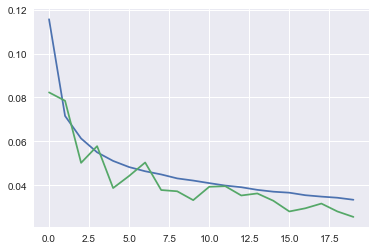

In [145]:
hc = covmodel1.fit(A.reshape(120000,170,1), y, batch_size=128, epochs=20, verbose=1,validation_data=(Aval.reshape(60000,170,1), yval))
plt.plot(hc.history['loss'])
plt.plot(hc.history['val_loss'])

Train on 80000 samples, validate on 30000 samples
Epoch 1/1
80000/80000 [==============================] - 1229s - loss: 0.2100 - mean_absolute_error: 0.3611 - val_loss: 0.1661 - val_mean_absolute_error: 0.3396


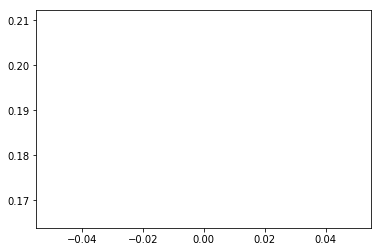

In [350]:
hc = model_m.fit(A.reshape(80000,370,1), y, batch_size=128, epochs=1, verbose=1,validation_data=(Aval.reshape(30000,370,1), yval))
plt.plot(hc.history['loss'])
plt.plot(hc.history['val_loss'])

In [349]:
model_m = Sequential()
model_m.add( Convolution1D( nb_filter=100, filter_length=10, input_shape=(A.shape[1], 1)))
model_m.add(Convolution1D(100, 10, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Convolution1D(160, 10, activation='relu'))
model_m.add(Convolution1D(160, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))

model_m.add(Dense(128, activation='relu'))
model_m.add(Dense(64, activation='relu'))
model_m.add(Dense(1))
model_m.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
model_m.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 361, 100)          1100      
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 352, 100)          100100    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 117, 100)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 108, 160)          160160    
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 99, 160)           256160    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 160)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 160)               0         
__________

/Users/johnwilson/anaconda/envs/ztdl/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=10, filters=100, input_shape=(370, 1))`
  


In [146]:
yfitc = covmodel1.predict(Aval.reshape(60000,170,1))

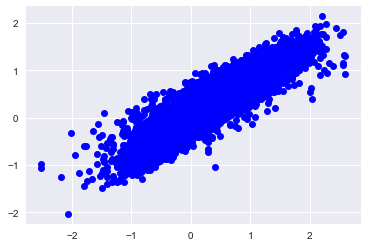

In [147]:
plt.plot(yval,yfitc,'bo')

In [148]:
np.corrcoef(yval.T,yfitc.T)

array([[ 1.        ,  0.94246068],
       [ 0.94246068,  1.        ]])

In [1365]:
maxvals = np.max(A,axis = 1).reshape(-1,1)
minvals = np.min(A,axis=1).reshape(-1,1)
As = (A-minvals)/(maxvals-minvals)
y = (y-minvals)/(maxvals-minvals)

maxvals = np.max(Aval,axis = 1).reshape(-1,1)
minvals = np.min(Aval,axis=1).reshape(-1,1)
Avals = (Aval-minvals)/(maxvals-minvals)
yval = (yval-minvals)/(maxvals-minvals)

In [1366]:
y[1]

array([-0.47448836])

In [1396]:
list1 = []
a = np.random.rand(10,1)
list1.append(a)

In [1399]:
list1.append(a)

In [1400]:
np.array(list1).shape

(4, 10, 1)

In [99]:
for p in np.arange(-1,1,.1):
    print(p)

-1.0
-0.9
-0.8
-0.7
-0.6
-0.5
-0.4
-0.3
-0.2
-0.1
-2.22044604925e-16
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
